# **Introduction to Image Processing**

** Dear students this is your first assignment in Image processing course, in the context of this assignment you have to:**
* **complete `2-enhancement.ipynb` up to section 2.7**
* **complete this notebook `2-enhancement-supplementary.ipynb`**
* **add your changes, commit and push your completed assignment to your github repo**

`2-enhancement-supplememtary.ipynb` provides more information on section 2.7

## 2.7 Your own implementation 

### Q.1 Import the required libraries and functions

In [1]:
% matplotlib inline
% pprint off

### import the libraries you think its necessary for your task

import matplotlib.pyplot as plt
import numpy as np
from skimage import io, img_as_ubyte, exposure

Pretty printing has been turned OFF


### Q.2 Contrast streching 

** Define your function which stretch the image contrast, `cont_str`, using minimum and maximum values from the image **

**This function should accept the input image, calculates the minimum and maximum and rescales the intensities.**

** Return the image as uint8 **

In [2]:
def cont_str(in_image):
    # Get min and max intensity values from image
    min_val = np.amin(in_image)
    max_val = np.amax(in_image)
    
    out_range = 255
    
    out_image = (in_image - min_val) / float(max_val - min_val)    
    out_image = (out_range * out_image)
    
    return out_image.astype('uint8')

**Use your function to transform the  gray version of `satellite.jpg` image (ubyte format), show the original image and the transformed image and their histogram**

C:\Users\dono_\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


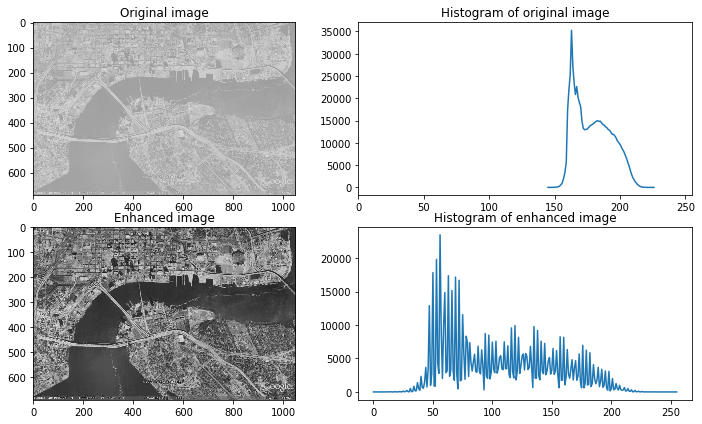

In [3]:
filename = './images/satellite.jpg'
sat_im = io.imread(filename,  as_grey = True)
sat_im_ubyte = img_as_ubyte(sat_im)

fig = plt.figure(figsize=(10,6))

# Show original image
plt.subplot (221)
io.imshow(sat_im)
plt.title('Original image')

sat_im_hist = exposure.histogram(sat_im_ubyte)
plt.subplot (222)
plt.plot(sat_im_hist[1], sat_im_hist[0])
plt.title('Histogram of original image')
plt.xlim(0,255)

# Apply cont_str transformation
sat_im_str = cont_str(sat_im)

# Show enhanced image
plt.subplot (223)
io.imshow(sat_im_str)
plt.title('Enhanced image')

sat_im_str_hist = exposure.histogram(sat_im_str)
plt.subplot (224)
plt.plot(sat_im_str_hist[1], sat_im_str_hist[0])
plt.title('Histogram of enhanced image')


### Q.3 Histogram equalization
Histogram equalization can be used to enhance the contrast in images.

The idea behind the histogram equalization process is that each gray level should have an equal contribution in the image. The function allowing such transformation is in fact the cumulative density function.

**Define your own histgram equalization function, `hist_eq`**

**This function should accept the image, max_int and min_int and return the transformed image and its cdf**

In [4]:
def hist_eq(image, min_int, max_int):
    interval = max_int - min_int

    # Find histogram and cdf
    bins, bins_c = np.histogram(image, 256)
    cdf = bins.cumsum() # cdf
    cdf = cdf / cdf[-1] # normalized cdf

    # Linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image, bins_c[:-1], interval*cdf)

    return image_equalized.astype('uint8'), cdf

** Use your function to transform the gray version of `satellite.jpg` image again in ubyte format**

** max_int = 255, min_int = 0 **

In [5]:
sat_im_histeq, cdf= hist_eq(sat_im, 0, 255)

**Show the transformed image and its histogram**

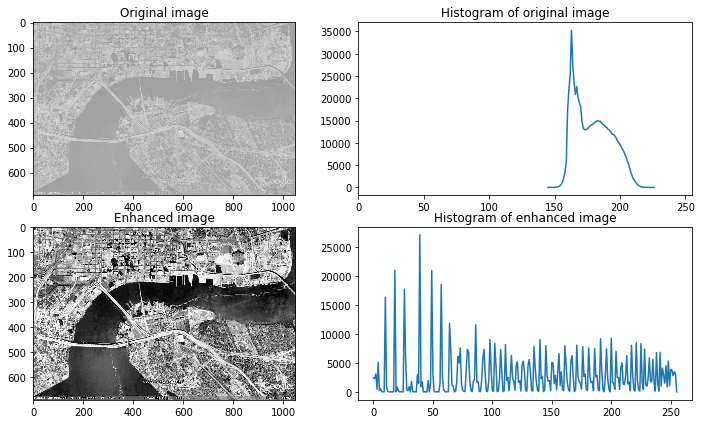

In [6]:
fig = plt.figure(figsize=(10,6))

# Show original image
plt.subplot (221)
io.imshow(sat_im)
plt.title('Original image')

sat_im_hist = exposure.histogram(sat_im_ubyte)
plt.subplot (222)
plt.plot(sat_im_hist[1], sat_im_hist[0])
plt.title('Histogram of original image')
plt.xlim(0,255)

# Show enhanced image
plt.subplot (223)
io.imshow(sat_im_histeq)
plt.title('Enhanced image')

sat_im_histeq_hist = exposure.histogram(sat_im_histeq)
plt.subplot (224)
plt.plot(sat_im_histeq_hist[1], sat_im_histeq_hist[0])
plt.title('Histogram of enhanced image')



### Q.4 Histogram matching

** In this section we will perform histogram matching, the `hist_match` function is mostly defined here**
** `hist_match` uses the function that should define the Q.3 `hist_eq`, check the comments in the code as well **
 
** Explain the process of histogram matching in your own words**

Histogram matching esentially consists in transforming an image according to a specified gray level histogram.
The main steps are:
1. Apply histogram equalization on the image to convert
2. Get the transformation function (CDF) of the pdf to fit
3. Apply the inverse transformation of the function in step 2 to the equalization in step 1


In [7]:
def find_inverse_mapping(mapping):
    # Initialise the inverse
    inv_mapping = np.zeros(mapping.shape)
    # Find the index that we can affect for sure
    idx_inv_map = np.unique(mapping)
    
    # For each index
    for idx in idx_inv_map:
        # Find the corresponding index value
        int_val = np.where(mapping == idx)[0][0]
        # Affect this value for the inverse mapping
        inv_mapping[idx] = int_val
        
    # Find the first index which is not zero
    first_elt_idx = np.nonzero(inv_mapping)[0][0]
    for i, elt in enumerate(inv_mapping[first_elt_idx:-1]):
        if (elt == 0):
            inv_mapping[i + first_elt_idx] = inv_mapping[i + first_elt_idx - 1]
        
    return inv_mapping.astype('uint8')



In [10]:
def hist_match(img, pdf_to_fit, min_int, max_int):
    # Equalize img
    
    ## hist_eq is actually the function that you should implement in the previous Question 
    img_eq, cdf_eq = hist_eq(img, min_int, max_int)
   
    
    # We need to make the matching now
    ## Compute the transform G
    
    ### Compute the cdf
    cdf = np.cumsum(pdf_to_fit)
    
    ### Multiply the cdf by the number of gray values
    cdf_real = cdf * float(max_int)
    ### Round the cdf
    G = np.floor(cdf_real).astype('int')
    
    ## But we need the inverse
    G_1 = find_inverse_mapping(G)
    
    img_match = np.zeros((img_eq.shape[0], img_eq.shape[1]))
    for i in range (np.shape(img_eq)[0]):
        for j in range (np.shape(img_eq)[1]):
            img_match[i][j] = G_1[int(img_eq[i][j])]
    
    return img_match.astype('uint8') # Changed as it was returning the image as float "out of standard range" 

**Creating a manual pdf following a gaussian distribution**

In [8]:
from scipy.stats import norm

max_img = 255

x = np.arange(max_img+1)
pdf_to_fit = norm.pdf(x, 150, 30)


**Use the defined function to match the histogram of gray version of satellite image to `pdf_to_fit`**

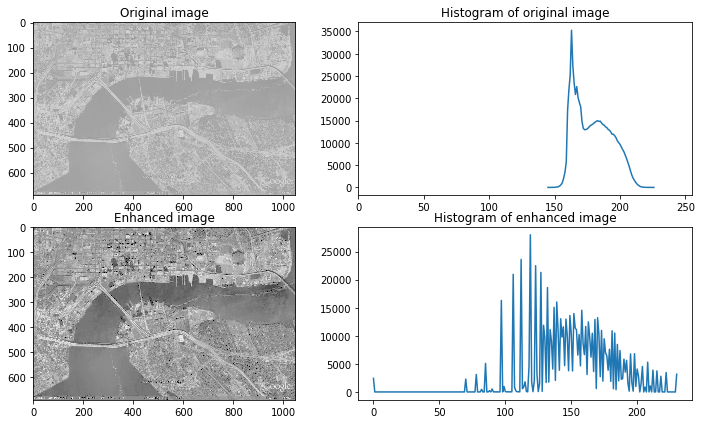

In [11]:
sat_im_fit = hist_match(sat_im, pdf_to_fit, 0, 255)

fig = plt.figure(figsize=(10,6))

# Show original image
plt.subplot (221)
io.imshow(sat_im)
plt.title('Original image')

sat_im_hist = exposure.histogram(sat_im_ubyte)
plt.subplot (222)
plt.plot(sat_im_hist[1], sat_im_hist[0])
plt.title('Histogram of original image')
plt.xlim(0,255)

# Show enhanced image
plt.subplot (223)
io.imshow(sat_im_fit)
plt.title('Enhanced image')

sat_im_fit_hist = exposure.histogram(sat_im_fit)
plt.subplot (224)
plt.plot(sat_im_fit_hist[1], sat_im_fit_hist[0])
plt.title('Histogram of enhanced image')


### Q.5 

** Explain the difference between log transform enhancement and gamma transform **


Long transforms expand range of dark image pixels while shrinking the range of bright pixels. Using the gamma transform a family of possible transformation curves can be obtained by only varying the $\gamma$ parameter. For $\gamma$ < 1 the range of dark image pixels are expanded and the range of bright ones are shrinked. For $\gamma$ > 1 the opposite effect is obtained. The transformation reduces to identity if $\gamma$ = 1.

** Explain how sigmoid function enhances the image **

Sigmoid enhancemtent is based on the phenomenon of simultaneous lightness contrast. It is possible to make the dark colors in an image look darker by making the light colors lighter. As the lightness difference between the highlight and shadow regions increases, the image contrast increases giving the appearance of a larger dynamic range. 